# CIFAR10 Classification Problem

### (1) Loading the CIFAR10 Dataset

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(images_train, labels_train), (images_test, labels_test) = cifar10.load_data()

labels = ['airplane', 
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

print(images_train.shape, images_test.shape)
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

(50000, 32, 32, 3) (10000, 32, 32, 3)


{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

We can have a look at some images

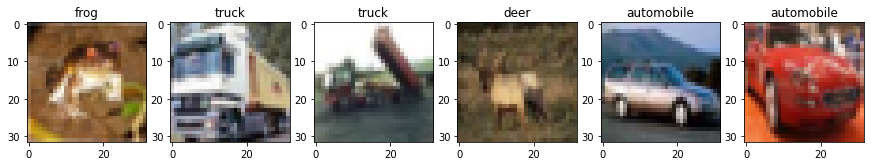

In [2]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(1,6, i+1)
    img = images_train[i]
    label = labels_train[i][0]
    plt.imshow(img)
    plt.title(labels[label])

### (2) Image preprocesing

In [3]:
### Normalizing pixels' intensities
X_train = images_train / 255
X_test = images_test / 255

### Encoding the labels
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(labels_train, 10)
y_test = to_categorical(labels_test, 10)

### (3) CNN architecture : initialize + compile + fit

In [4]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def initialize_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation = 'relu', padding = 'same', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (2, 2), activation = 'relu', padding = 'same'))
    model.add(Dropout(0.3))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [5]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0

In [6]:
from tensorflow.keras import optimizers

def compile_model(model):
    model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])
    return model

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

model = initialize_model()
model = compile_model(model)

es = EarlyStopping(patience = 5)

history = model.fit(X_train, y_train, 
                    validation_split = 0.3,
                    callbacks = [es], 
                    epochs = 100, 
                    batch_size = 64,
                   verbose = 1)

Epoch 1/100
547/547 [==============================] - 9s 9ms/step - loss: 1.8173 - accuracy: 0.3279 - val_loss: 1.5327 - val_accuracy: 0.4625
Epoch 2/100
547/547 [==============================] - 3s 6ms/step - loss: 1.4920 - accuracy: 0.4550 - val_loss: 1.3904 - val_accuracy: 0.5131
Epoch 3/100
547/547 [==============================] - 3s 6ms/step - loss: 1.3842 - accuracy: 0.5017 - val_loss: 1.2839 - val_accuracy: 0.5667
Epoch 4/100
547/547 [==============================] - 4s 7ms/step - loss: 1.3072 - accuracy: 0.5316 - val_loss: 1.2216 - val_accuracy: 0.5865
Epoch 5/100
547/547 [==============================] - 3s 6ms/step - loss: 1.2361 - accuracy: 0.5577 - val_loss: 1.2315 - val_accuracy: 0.5695
Epoch 6/100
547/547 [==============================] - 3s 6ms/step - loss: 1.1885 - accuracy: 0.5746 - val_loss: 1.1336 - val_accuracy: 0.6103
Epoch 7/100
547/547 [==============================] - 4s 7ms/step - loss: 1.1545 - accuracy: 0.5898 - val_loss: 1.0878 - val_accuracy: 0.6321

We can plot the loss and accuracy

In [8]:
def plot_history(history):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(history.history['loss'], label = 'train')
    ax1.plot(history.history['val_loss'], label = 'val')
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy')
    ax2.plot(history.history['val_accuracy'], label='val accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()

    return (ax1, ax2)

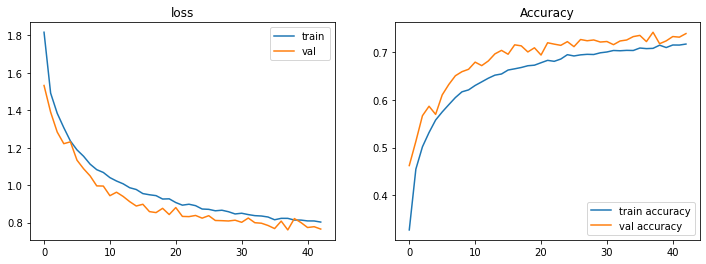

In [9]:
plot_history(history)
plt.show()

### (4) Evaluating the model on the test data and comparing it with a baseline accuracy

In [10]:
res = model.evaluate(X_test, y_test, verbose = 0)

print(f'The accuracy is {res[1]*100:.3f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 73.750% compared to a chance level of 10.0%


### (5) Using data augmentation to re-train the model

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = (0.8, 1.2),
    ) 

datagen.fit(X_train)
datagen

In [12]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
X_augmented_iterator

Visualizing the augmented images

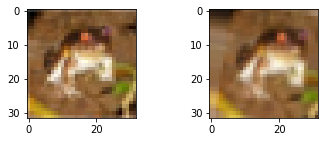

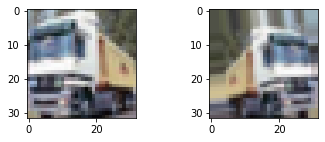

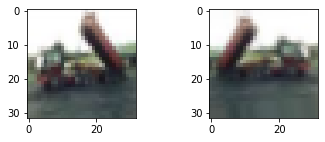

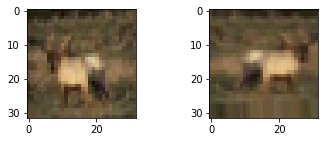

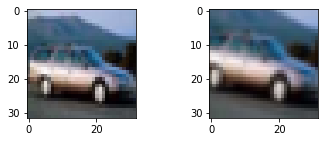

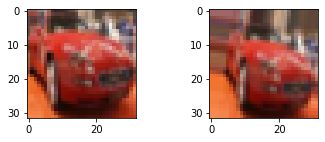

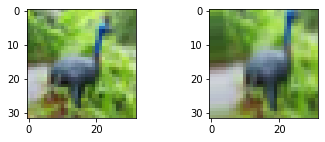

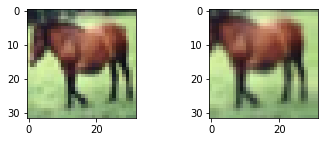

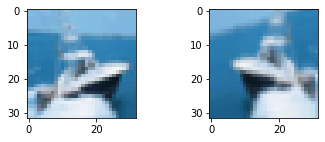

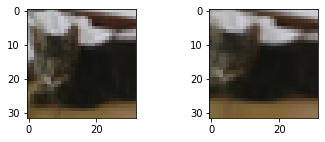

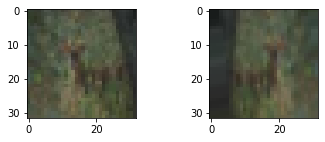

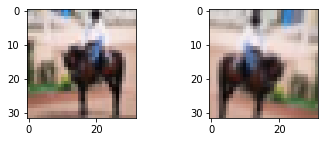

In [13]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()
    
    if i > 10:
        break

We have to define the **`validation_data`** manually with the following commands to avoid data leakage

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

# The model
model_aug = initialize_model()
model_aug = compile_model(model_aug)

# The data generator
X_tr = X_train[:40000]
y_tr = y_train[:40000]
X_val = X_train[40000:]
y_val = y_train[40000:]
train_flow = datagen.flow(X_tr, y_tr, batch_size = 64)

# The early stopping criterion
es = EarlyStopping(patience = 3)

# The fit
history_aug = model_aug.fit(train_flow, 
                        epochs = 50, 
                        callbacks = [es], 
                        validation_data = (X_val, y_val))


Epoch 1/50
625/625 [==============================] - 25s 38ms/step - loss: 1.8860 - accuracy: 0.2966 - val_loss: 1.6218 - val_accuracy: 0.4278
Epoch 2/50
625/625 [==============================] - 24s 38ms/step - loss: 1.6408 - accuracy: 0.3959 - val_loss: 1.4827 - val_accuracy: 0.4797
Epoch 3/50
625/625 [==============================] - 23s 37ms/step - loss: 1.5741 - accuracy: 0.4252 - val_loss: 1.4836 - val_accuracy: 0.4762
Epoch 4/50
625/625 [==============================] - 23s 37ms/step - loss: 1.5187 - accuracy: 0.4471 - val_loss: 1.3862 - val_accuracy: 0.5318
Epoch 5/50
625/625 [==============================] - 24s 38ms/step - loss: 1.4792 - accuracy: 0.4645 - val_loss: 1.3327 - val_accuracy: 0.5303
Epoch 6/50
625/625 [==============================] - 24s 38ms/step - loss: 1.4390 - accuracy: 0.4794 - val_loss: 1.2631 - val_accuracy: 0.5522
Epoch 7/50
625/625 [==============================] - 23s 38ms/step - loss: 1.4079 - accuracy: 0.4919 - val_loss: 1.2411 - val_accuracy:

We plot the result and evaluate the augmented model

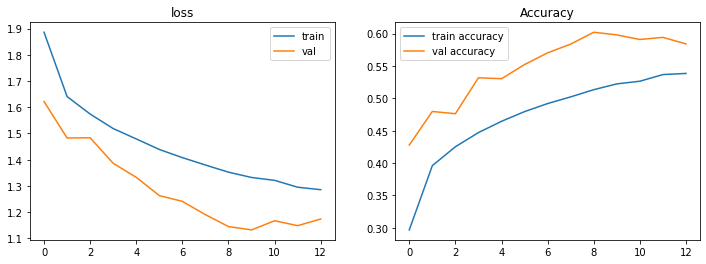

In [16]:
plot_history(history_aug)
plt.show()

In [17]:
res_1 = model.evaluate(X_test, y_test, verbose = 0)

res_2 = model_aug.evaluate(X_test, y_test, verbose = 1)

print(f'Accuracy without data augmentation {res_1[1]*100:.2f}%')
print(f'Accuracy with data augmentation {res_2[1]*100:.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 1.1711 - accuracy: 0.5867
Accuracy without data augmentation 73.75%
Accuracy with data augmentation 58.67%


Data augmentation may not improve the performance easily. Here it even decreased it.

Some ways to overcome this issue would depend on the model architecture, the learning rate, type of augmentation chosen, etc...